In [4]:
import numpy as np
import pandas as pd
from os import path
import os
import sys
import platform
from matplotlib import pyplot as plt
import qgrid

# Binary Format

In [52]:
def load_oo_events(rec_folder):
    #define event folde
    if platform.system() == 'Linux':
        event_folder = rec_folder+r"/events/Rhythm_FPGA-100.0/TTL_1"
    elif platform.system() == 'Windows':
        event_folder = rec_folder+r"\events\Rhythm_FPGA-100.0\TTL_1"
    elif platform.system() == 'Darwin': #macos
        event_folder = rec_folder+r"/events/Rhythm_FPGA-100.0/TTL_1"
    
    # load infos
    channel_states_ar = np.load(path.join(event_folder,'channel_states.npy'))
    channels_ar = np.load(path.join(event_folder,'channels.npy'))
    #text_ar = np.load(path.join(event_folder,'text.npy'))
    full_words = np.load(path.join(event_folder,'full_words.npy'))
    timestamps_ar = np.load(path.join(event_folder,'timestamps.npy'))
    # normalize
    timestamps_nor_ar = timestamps_ar - timestamps_ar[0]
    
    # create array
    oe_events_ar = np.zeros([timestamps_nor_ar.shape[0],5])
    oe_events_ar[:,0]=timestamps_ar
    oe_events_ar[:,1]=timestamps_nor_ar/30
    oe_events_ar[:,2]=timestamps_nor_ar/30000
    oe_events_ar[:,3]=channel_states_ar
    oe_events_ar[:,4]=channels_ar
    
    # create dataframe
    oe_events_df = pd.DataFrame(oe_events_ar,columns=["samplerate_absolut","ms_relativ","s_relativ","event","channel"])
    return oe_events_df

def extract_events_oo(oe_events_df):
    oe_sync_df = (oe_events_df.loc[np.logical_or(oe_events_df['channel']==1, oe_events_df['channel']==2)]).copy()
    oe_sync_df.reset_index(inplace=True,drop=True)
    oe_trials = []

    trial=False
    bnc1=-1
    bnc2=-1
    for row in  oe_sync_df.index.values[1:]:
        # check bnc state
        if oe_sync_df.loc[row,"channel"]==1:
            bnc1=oe_sync_df.loc[row,"event"]
        if oe_sync_df.loc[row,"channel"]==2:
            bnc2=oe_sync_df.loc[row,"event"]
        # 1 2 = start
        if oe_sync_df.loc[row,"event"]==2 and oe_sync_df.loc[row-1,"event"]==1:
            if oe_sync_df.loc[row,"ms_relativ"]==oe_sync_df.loc[row-1,"ms_relativ"]:
                if trial == False:
                    oe_trials.append([oe_sync_df.loc[row,"ms_relativ"],"start"])
                    #oe_trials.append([oe_sync_df.loc[row+1,"ms_relativ"],"event"])
                    trial=True
                elif trial == True:
                    oe_trials.append([oe_sync_df.loc[row,"ms_relativ"],"event"])
                    oe_trials.append([oe_sync_df.loc[row+1,"ms_relativ"],"event"])
                    oe_trials.append([oe_sync_df.loc[row+1,"ms_relativ"],"end"])
                    trial=False

        # 1 0 = reward event
        if oe_sync_df.loc[row,"channel"]==1 and trial:
            if not(oe_sync_df.loc[row+1,"channel"]==2 and oe_sync_df.loc[row,"ms_relativ"]==oe_sync_df.loc[row+1,"ms_relativ"]):
                oe_trials.append([oe_sync_df.loc[row,"ms_relativ"],"reward_event"])
                #oe_events.append([oe_sync_df.loc[row+1,"s_relativ"],"reward_end"])

        # 0 1 = normal event
        if oe_sync_df.loc[row,"channel"]==2:
            if not(oe_sync_df.loc[row-1,"event"]==1 and oe_sync_df.loc[row,"ms_relativ"]==oe_sync_df.loc[row-1,"ms_relativ"]) and trial:
                oe_trials.append([oe_sync_df.loc[row,"ms_relativ"],"event"])
                #oe_events.append([oe_sync_df.loc[row+1,"s_relativ"],"reward_end"])


    oe_trials_df = pd.DataFrame(oe_trials,columns=["ms_relativ","event_type"]) 
    return oe_trials_df

def convert_to_seconds(csv_string):
    utc_time = datetime.strptime(csv_string,
                                "%Y-%m-%d %H:%M:%S.%f"
                                )
    return utc_time.timestamp()

def load_bp_events(root_dir,session):
    #specify path
    if platform.system() == 'Linux':
        event_folder = (root_dir + "/experiments/gamble_task/setups/gamble_task_recording/sessions")
    elif platform.system() == 'Windows':
        folder = (root_dir + r"\experiments\gamble_task\setups\gamble_task_recording\sessions")
    elif platform.system() == 'Darwin': #macos
        folder= (root_dir + "/experiments/gamble_task/setups/gamble_task_recording/sessions")
    
    ext = ".csv"
    # read csv
    session_df = pd.read_csv(path.join(folder,session,session)+ext,sep=';',header=6)
    #convert string to datetime
    session_df["datetime"]=(pd.to_datetime(session_df["PC-TIME"].values,format="%Y-%m-%d %H:%M:%S.%f")).values
    # get milliseconds
    session_df["ms_absolut"]=session_df["datetime"].apply(lambda x: x.timestamp()*1000)
    session_df["ms_relativ"]=session_df["ms_absolut"]-session_df.loc[14,"ms_absolut"]

    return session_df

def get_sync(openephys_dir,pybpod_root,pybpod_session):
    # load openephys ttl
    oe_events_df = load_oo_events(openephys_dir)
    # load pybpod events
    pb_events_df = load_bp_events(pybpod_root,pybpod_session)
    
    # conver ttl to events
    oe_trials_df = extract_events_oo(oe_events_df)
    
    # create combined df
    # select bpod necessary files
    selector = np.logical_or(np.logical_or(pb_events_df.TYPE=="TRANSITION",pb_events_df.TYPE=="TRIAL"),pb_events_df.TYPE=="END-TRIAL")
    pb_sync_df = pb_events_df.loc[selector,["MSG","ms_relativ","BPOD-INITIAL-TIME"]]
    # combine both
    combined_ar = np.zeros([pb_sync_df.shape[0],4],dtype=object)
    combined_ar[:oe_trials_df.shape[0],[0,2]]=oe_trials_df.values
    combined_ar[:pb_sync_df.shape[0],[1,3]]=pb_sync_df.loc[:,["ms_relativ","MSG"]].values
    combined_df=pd.DataFrame(combined_ar,columns=["oe_ms_relativ","pb_ms_relativ","oe_event","pb_event"])
    combined_df["delta_pb_oe"]=combined_df["pb_ms_relativ"]-combined_df["oe_ms_relativ"]
    
    return combined_df

# Plotting =============================================================================================

def plt_start_stop_dif(combined_df):
    # get data
    start=(combined_df.loc[combined_df['pb_event']=='New trial']).copy()
    start.reset_index(inplace=True,drop=True)
    stop=(combined_df.loc[combined_df['pb_event']=='The trial ended']).copy()
    stop.reset_index(inplace=True,drop=True)

    # plot data
    fig,ax = plt.subplots()
    ax.plot(start['delta_pb_oe'],color='r',label='start')
    ax.plot(stop['delta_pb_oe'],color='g',label='end')

    # labeling
    ax.set_xlabel("trial number")
    ax.set_ylabel("diff pb-oe [ms]")
    ax.grid()
    fig.legend()
    
    return fig,ax


In [26]:
openephys_dir = r"C:\maxland_RECORDING\openephys\2021-02-19_15-54-34\Record Node 101\experiment1\recording1"
pybpod_session = "20210219-155417"
pybpod_root = r"C:\maxland_RECORDING"

In [27]:
combined_df = get_sync(openephys_dir,pybpod_root,pybpod_session)
qgrid.show_grid(combined_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='trial number', ylabel='diff pb-oe [ms]'>)

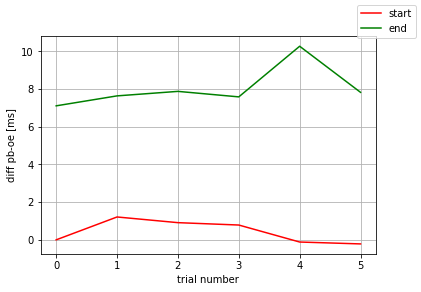

In [53]:
plt_start_stop_dif(combined_df)

## Load OpenEphys Events

In [10]:
oe_events_df = load_oo_events(openephys_dir)
qgrid.show_grid(oe_events_df)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Plot

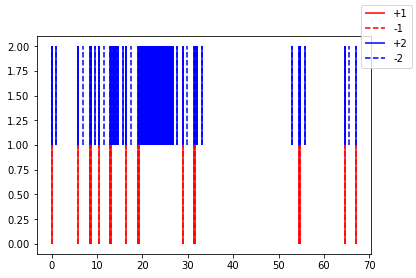

In [20]:
fig,ax = plt.subplots()
ax.vlines(oe_events_df.loc[oe_events_df.event==1,"s_relativ"], 0,1, label='+1', color ='r')
ax.vlines(oe_events_df.loc[oe_events_df.event==-1,"s_relativ"], 0,1, label='-1', color ='r',linestyle='--')

ax.vlines(oe_events_df.loc[oe_events_df.event==2,"s_relativ"], 1,2, label='+2', color ='b')
ax.vlines(oe_events_df.loc[oe_events_df.event==-2,"s_relativ"], 1,2, label='-2', color ='b',linestyle='--')

#ax.vlines(ch2, 0,1, label='2', color='grey', alpha=0.5)
#ax.vlines(ch5, 0,1, label='5',color='grey', alpha=0.5)
fig.legend()

## Load PyBpod Events

In [11]:
pb_events_df = load_bp_events(pybpod_root,pybpod_session)

selector = np.logical_or(pb_events_df.TYPE=="TRANSITION",pb_events_df.TYPE=="TRIAL")
pb_sync_df = pb_events_df.loc[selector,["MSG","ms_relativ","BPOD-INITIAL-TIME"]]
pb_sync_df.reset_index(drop=True,inplace=True)

qgrid.show_grid(pb_events_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [12]:
oe_trials_df = extract_events_oo(oe_events_df)
qgrid.show_grid(oe_trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Combine Both

In [240]:
selector = np.logical_or(pb_events_df.TYPE=="TRANSITION",pb_events_df.TYPE=="TRIAL")
pb_sync_df = pb_events_df.loc[selector,["MSG","ms_relativ","BPOD-INITIAL-TIME"]]

combined_ar = np.zeros([pb_sync_df.shape[0],4],dtype=object)
combined_ar[:oe_trials_df.shape[0],[0,2]]=oe_trials_df.values
combined_ar[:pb_sync_df.shape[0],[1,3]]=pb_sync_df.loc[:,["ms_relativ","MSG"]].values
combined_df=pd.DataFrame(combined_ar,columns=["oe_ms_relativ","pb_ms_relativ","oe_event","pb_event"])
combined_df["delta_pb_oe"]=combined_df["pb_ms_relativ"]-combined_df["oe_ms_relativ"]

qgrid.show_grid(combined_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Workbench